In [1]:
from condastats.cli import overall, pkg_platform, pkg_version, pkg_python, data_source
import s3fs
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
df = overall('arm_pyart', start_month='2019-01', end_month='2022-06', monthly=True)

In [60]:
df["time"] = pd.to_datetime(df.time)
df.index = df.time

In [70]:
conda_downloads = df["counts"]

In [62]:
pypi = pd.read_csv("../data/pypi_stats.csv",
                   parse_dates=True,
                   index_col='month')

In [69]:
pypi_downloads = pypi["arm-pyart"]

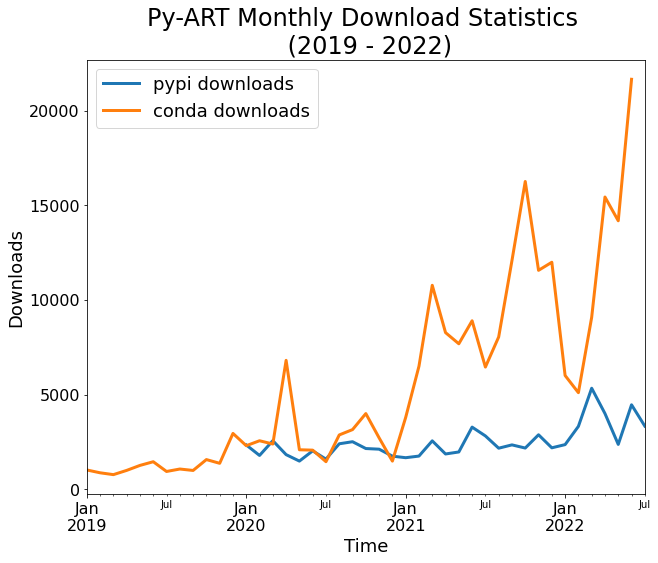

In [89]:
fig = plt.figure(figsize=(10,8))
pypi_downloads.plot(linewidth=3, label='pypi downloads')
conda_downloads.plot(linewidth=3, label='conda downloads')
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Downloads", fontsize=18)
plt.title("Py-ART Monthly Download Statistics \n (2019 - 2022)",
          fontsize=24);
plt.savefig("monthly_download_stats_through_june_2022.png", dpi=300, transparent=False, facecolor='white')

In [61]:
df = pd.read_csv("../data/github_commits.csv", index_col='date', parse_dates=True)

In [59]:
INTERNAL_AUTHORS = set(['zssherman', 'rcjackson', 'scollis', 'mgrover1', 'jhemedin', 'AdamTheisen'])
def get_commits_data():
    def author_type(author):
        if author in INTERNAL_AUTHORS:
            return 'Internal'
        elif '[bot]' in str(author):
            return None
        else:
            return 'External'

    df = pd.read_csv('../data/github_commits.csv', index_col='date', parse_dates=True) \
           .sort_index() \
           .tz_localize(None)
    df['changes'] = df.additions + df.deletions
    df['author_type'] = df.author.apply(author_type)
    df = df.drop(columns=['additions', 'deletions'])
    return df

In [60]:
df = get_commits_data()

In [44]:
df_c = df

In [45]:
df.head()

,package,author,changes,author_type
date,,,,
2012-09-07 17:46:26,pyart,NaN,156,External
2012-09-11 17:17:13,pyart,NaN,42,External
2012-09-11 17:21:57,pyart,NaN,1,External
2012-09-11 17:26:50,pyart,NaN,1,External
2012-09-11 17:30:12,pyart,NaN,2406,External


In [46]:
def make_contributor_images(df_c: pd.DataFrame):
    def cumsum_unique_authors(data):
        data['authors'] = data['authors'].cumsum().map(set).map(len)
        return data

df_c = df_c.drop(columns='changes').dropna()
idx = pd.MultiIndex.from_product([
    pd.period_range(start=df_c.index.min(), end=df_c.index.max(), freq='M'),
    df_c.package.unique(),
    df_c.author_type.unique(),
], names=['month', 'package', 'author_type'])
df_c = df_c.groupby([df_c.index.to_period('M'), 'package', 'author_type']) \
           .agg(list) \
           .rename(columns={'author': 'authors'}) \
           .reindex(idx, fill_value=[]) \
           .reset_index(['package', 'author_type']) \
           .groupby(['package', 'author_type']) \
           .apply(cumsum_unique_authors)

for pkg in df_c.package.unique():
    df = df_c.loc[df_c.package == pkg] \
             .drop(columns='package') \
             .reset_index() \
             .pivot(index='month', columns='author_type', values='authors') \
             .astype('int64')
    filename = f'images/metrics/{pkg}-contributors.html'
    title = 'Number of Contributors'
   # _make_stacked_bar_plot(df, filename, title, 'Contributors')

NameError: name '_make_stacked_bar_plot' is not defined

<AxesSubplot:xlabel='month'>

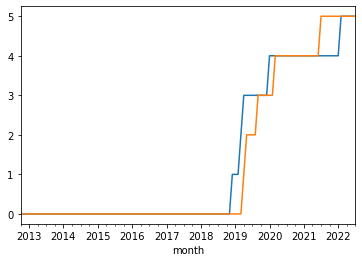

In [58]:
df.Internal.plot.line()
df.External.plot.line()